<a href="https://colab.research.google.com/github/sachi9004/AnalyticsVidhya_BlackFriday/blob/master/Video_Analytics_final_sample(for_ref).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images

In [3]:
import zipfile

def main():

    # assigning filename to a variable
    file_name = '/content/drive/My Drive/Hackathons/Earthackers/96714c94-6-Dataset.zip'

    # opening Zip using 'with' keyword in read mode
    with zipfile.ZipFile(file_name, 'r') as file:
        # printing all the information of archive file contents using 'printdir' method
        print(file.printdir())

        # extracting the files using 'extracall' method
        print('Extracting all files...')
        file.extractall()
        print('Done!') # check your directory of zip file to see the extracted files

if __name__ == '__main__': main()

File Name                                             Modified             Size
Dataset/                                       2020-03-16 18:31:10            0
Dataset/Test Tom and Jerry.mp4                 2020-03-12 07:48:34     21682364
Dataset/Test.csv                               2020-03-16 18:31:24         2130
Dataset/Train Tom and jerry.mp4                2020-03-12 07:28:58     25644389
Dataset/Train.csv                              2020-03-16 18:25:24         5992
None
Extracting all files...
Done!


In [4]:
count = 0
videoFile = "/content/Dataset/Train Tom and jerry.mp4"
cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="frame%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


Let us try to visualize an image (frame). We will first read the image using the imread() function of matplotlib, and then plot it using the imshow() function.

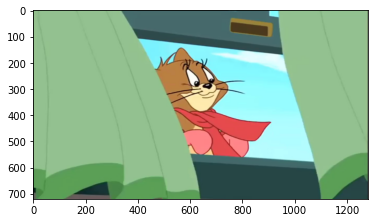

In [5]:
img = plt.imread('frame0.jpg')   # reading image using its name
plt.imshow(img)

In [6]:
data=pd.read_csv('/content/Dataset/mapping.csv')
data.head()

,Image_ID,Class
0,frame0.jpg,1
1,frame1.jpg,1
2,frame2.jpg,2
3,frame3.jpg,2
4,frame4.jpg,2


Our next step is to read the images which we will do based on their names, aka, the Image_ID column.



In [0]:
X = [ ]     # creating an empty array
for img_name in data.Image_ID:
    img = plt.imread('' + img_name)
    X.append(img)  # storing each image in array X
X = np.array(X)    # converting list to array

Since there are three classes, we will one hot encode them using the to_categorical() function of keras.utils.

In [0]:
y = data.Class
dummy_y = np_utils.to_categorical(y)    # one hot encoding Classes

We will be using a VGG16 pretrained model which takes an input image of shape (224 X 224 X 3). Since our images are in a different size, we need to reshape all of them. We will use the resize() function of skimage.transform to do this

In [0]:
image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(224,224)).astype(int)      # reshaping to 224*224*3
    image.append(a)
X = np.array(image)

All the images have been reshaped to 224 X 224 X 3. But before passing any input to the model, we must preprocess it as per the model’s requirement. Otherwise, the model will not perform well enough. Use the preprocess_input() function of keras.applications.vgg16 to perform this step.

In [0]:
from keras.applications.vgg16 import preprocess_input
X = preprocess_input(X, mode='tf')      # preprocessing the input data

We also need a validation set to check the performance of the model on unseen images. We will make use of the train_test_split() function of the sklearn.model_selection module to randomly divide images into training and validation set.

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, dummy_y, test_size=0.3, random_state=42)    # preparing the validation set

Step 3: Building the model
The next step is to build our model. As mentioned, we shall be using the VGG16 pretrained model for this task. Let us first import the required libraries to build the model:

In [0]:
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout

We will now load the VGG16 pretrained model and store it as base_model:

In [13]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))    # include_top=False to remove the top layer





58892288/58889256 [==============================] - 2s 0us/step








We will make predictions using this model for X_train and X_valid, get the features, and then use those features to retrain the model.

In [14]:
X_train = base_model.predict(X_train)
X_valid = base_model.predict(X_valid)
X_train.shape, X_valid.shape

((208, 7, 7, 512), (90, 7, 7, 512))

The shape of X_train and X_valid is (208, 7, 7, 512), (90, 7, 7, 512) respectively. In order to pass it to our neural network, we have to reshape it to 1-D.

In [0]:
X_train = X_train.reshape(208, 7*7*512)      # converting to 1-D
X_valid = X_valid.reshape(90, 7*7*512)

We will now preprocess the images and make them zero-centered which helps the model to converge faster.

In [0]:
train = X_train/X_train.max()      # centering the data
X_valid = X_valid/X_train.max()

Finally, we will build our model. This step can be divided into 3 sub-steps:

Building the model
Compiling the model
Training the model

In [0]:
# i. Building the model
model = Sequential()
model.add(InputLayer((7*7*512,)))    # input layer
model.add(Dense(units=1024, activation='sigmoid')) # hidden layer
model.add(Dense(3, activation='softmax'))    # output layer

Let’s check the summary of the model using the summary() function:

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 25,694,211
Trainable params: 25,694,211
Non-trainable params: 0
_________________________________________________________________


We have a hidden layer with 1,024 neurons and an output layer with 3 neurons (since we have 3 classes to predict). Now we will compile our model:

In [19]:
# ii. Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In the final step, we will fit the model and simultaneously also check its performance on the unseen images, i.e., validation images:

In [20]:
# iii. Training the model
model.fit(train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 208 samples, validate on 90 samples
Epoch 1/100
208/208 [==============================] - 1s 4ms/step - loss: 1.0821 - acc: 0.5721 - val_loss: 1.2584 - val_acc: 0.4333
Epoch 2/100
208/208 [==============================] - 0s 470us/step - loss: 0.5391 - acc: 0.7596 - val_loss: 0.7540 - val_acc: 0.6889
Epoch 3/100
208/208 [==============================] - 0s 462us/step - loss: 0.2968 - acc: 0.8798 - val_loss: 0.5734 - val_acc: 0.7333
Epoch 4/100
208/208 [==============================] - 0s 471us/step - loss: 0.1733 - acc: 0.9471 - val_loss: 0.3927 - val_acc: 0.8333
Epoch 5/100
208/208 [==============================] - 0s 461us/step - loss: 0.0880 - acc: 0.9808 - val_loss: 0.3954 - val_acc: 0.8222
Epoch 6/100
208/208 [==============================] - 0s 482us/step - loss: 0.0592 - acc: 0.9952 - val_loss: 0.3546 - val_acc: 0.8333
Epoch 7/100
208/208 [==============================

# iii. Training the model
model.fit(train, y_train, epochs=100, validation_data=(X_valid, y_valid))

In the next section, we will try to calculate the screen time of TOM and JERRY in a Test video.

 

First, download the video we’ll be using in this section from here. Once done, go ahead and load the video and extract frames from it. We will follow the same steps as we did above:

In [21]:
count = 0
videoFile = "/content/Dataset/Test Tom and Jerry.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="test%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


After extracting the frames from the new video, we will now load the test.csv file which contains the names of each extracted frame. Download the test.csv file and load it:

In [0]:
test = pd.read_csv('/content/Dataset/test.csv')

In [23]:
test.head()


,Image_ID
0,test0.jpg
1,test1.jpg
2,test2.jpg
3,test3.jpg
4,test4.jpg


Next, we will import the images for testing and then reshape them as per the requirements of the aforementioned pretrained model:

In [0]:
test_image = []
for img_name in test.Image_ID:
    img = plt.imread('' + img_name)
    test_image.append(img)
test_img = np.array(test_image)

In [0]:
test_image = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(224,224)).astype(int)
    test_image.append(a)
test_image = np.array(test_image)


We need to make changes to these images similar to the ones we did for the training images. We will preprocess the images, use the base_model.predict() function to extract features from these images using the VGG16 pretrained model, reshape these images to 1-D form, and make them zero-centered:
---



In [0]:
# preprocessing the images
test_image = preprocess_input(test_image, mode='tf')

# extracting features from the images using pretrained model
test_image = base_model.predict(test_image)

# converting the images to 1-D form
test_image = test_image.reshape(186, 7*7*512)

# zero centered images
test_image = test_image/test_image.max()

Since we have trained the model previously, we will make use of that model to make prediction for these images.

In [0]:
predictions = model.predict_classes(test_image)

Step – 5 Calculate the screen time of both TOM and JERRY
Recall that Class ‘1’ represents the presence of JERRY, while Class ‘2’ represents the presence of TOM. We shall make use of the above predictions to calculate the screen time of both these legendary characters:

In [28]:
print("The screen time of JERRY is", predictions[predictions==1].shape[0], "seconds")
print("The screen time of TOM is", predictions[predictions==2].shape[0], "seconds")

The screen time of JERRY is 6 seconds
The screen time of TOM is 113 seconds


Now for final submission , we will write the .csv file for final predict.

In [0]:
df = pd.DataFrame(predictions) 
  
# saving the dataframe 
df.to_csv('final_predict.csv') 

Just a random check of the result

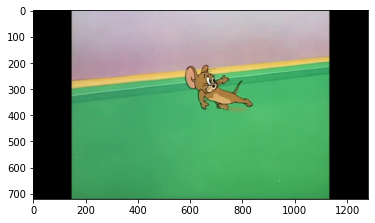

In [30]:
img = plt.imread('test46.jpg')   # reading image using its name
plt.imshow(img)

My learnings – what worked and what did not
I tried and tested many things for this challenge – some worked exceedingly well, while some ended up flat. In this section, I will elaborate a bit on some of the difficulties I faced, and then how I tackled them. After that, I have provided the entire code for the final model which gave me the best accuracy.

First, I tried using the pretrained model without removing the top layer. The results were not satisfactory. The possible reason could be that these are the cartoon images and our pretrained model was trained on actual images and hence it was not able to classify these cartoon images. To tackle this problem, i retrained the pretrain model using few labelled images and the results were better from the previous results.

Even after training on the labelled images, the accuracy was not satisfactory. The model was not able to perform well on the training images itself. So, i tried to increase the number of layers. Increasing the number of layers proved to be a good solution to increase the training accuracy but there was no sync between training and validation accuracy. The model was overfitting and its performance on the unseen data was not satisfactory. So I added a Dropout layer after every Dense layer and then there was good sync between training and validation accuracy.

I noticed that the classes are imbalanced. TOM had more screen time so the predictions were dominated by it and most of the frames were predicted as TOM. To overcome this and make the classes balanced, i used compute_class_weight() function of sklearn.utils.class_weight module. It assigned higher weights to the classes with lower value counts as compared to the classes with higher value counts.

I also used Model Checkpointing to save the best model, i.e. the model which produced lowest validation loss and then used that model to make the final predictions. I will summarize all the above mentioned steps and will give the final code now. The actual classes for the testing images can be found in testing.csv file.

Now repeating the codes with above said recommendations

In [0]:
from keras.utils import np_utils
train_y = np_utils.to_categorical(data.Class)


In [33]:
model = Sequential()
model.add(InputLayer((7*7*512,)))    # input layer
model.add(Dense(units=1024, activation='sigmoid'))   # hidden layer
model.add(Dropout(0.5))      # adding dropout
model.add(Dense(units=512, activation='sigmoid'))    # hidden layer
model.add(Dropout(0.5))      # adding dropout
model.add(Dense(units=256, activation='sigmoid'))    # hidden layer
model.add(Dropout(0.5))      # adding dropout
model.add(Dense(3, activation='softmax'))            # output layer


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
class_weights = compute_class_weight('balanced',np.unique(data.Class), data.Class)  # computing weights of different classes

In [0]:
from keras.callbacks import ModelCheckpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]      # model check pointing based on validation loss

In [37]:
model.fit(train, y_train, epochs=100, validation_data=(X_valid, y_valid), class_weight=class_weights, callbacks=callbacks_list)

Train on 208 samples, validate on 90 samples
Epoch 1/100
208/208 [==============================] - 1s 4ms/step - loss: 1.3304 - acc: 0.3798 - val_loss: 1.2156 - val_acc: 0.2444

Epoch 00001: val_loss improved from inf to 1.21558, saving model to weights.best.hdf5
Epoch 2/100
208/208 [==============================] - 0s 626us/step - loss: 1.3735 - acc: 0.2885 - val_loss: 1.1116 - val_acc: 0.5667

Epoch 00002: val_loss improved from 1.21558 to 1.11162, saving model to weights.best.hdf5
Epoch 3/100
208/208 [==============================] - 0s 577us/step - loss: 1.2217 - acc: 0.3990 - val_loss: 1.0235 - val_acc: 0.3889

Epoch 00003: val_loss improved from 1.11162 to 1.02345, saving model to weights.best.hdf5
Epoch 4/100
208/208 [==============================] - 0s 592us/step - loss: 1.1705 - acc: 0.4183 - val_loss: 0.9956 - val_acc: 0.4333

Epoch 00004: val_loss improved from 1.02345 to 0.99563, saving model to weights.best.hdf5
Epoch 5/100
208/208 [==============================] - 0s

In [0]:
model.load_weights("weights.best.hdf5")

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])